<font color = red>TITLE: </font> PREDICTIVE MODELING OF PROCESS OUTPUT<br><br>
<font color = red>GENERAL DESCRIPTION:</font> The objective of this project is to build a model to predict product results from 15 measurements (at "Stage 1") based on the raw material input properties and the machine processing parameters used to manufacture the product. <br> <br>
<font color = red>COMMENTS:</font>
- In code blocks `#checked` means the output was verified
- Major steps in the analysis are in large font and bold
- From my experience in process industries, it would be useful to the business operating this process if the predictive model parameters had physical meaning. This would allow the business to better understand which process parameters can be modified to reduce variation, reduce scrap, increase throughput, etc.  Regression provides parameters that operators and engineers can use to improve the manufacturing operation.
- The process parameters temperature, humidity, amperage, rpm, feed rate are all continuous.  Based on my experience raw material properties can be categorical (or numeric ordinal) or continous.
- With most of the process parameters being continuous, modeling will be by regression.
<br>

Start by 

1.  Importing Python libraries for data processing and visualization
2.  Reading in dataset
3.  Viewing its structure and size

In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv(r"/kaggle/input/"
                 r"multistage-continuousflow-manufacturing-process"
                 r"/continuous_factory_process.csv")
pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows", 150)
print('df shape:', df.shape)
df.head(2)

# Note: For a Kaggle notebook, any results written to  
# the current directory are saved as output.

/kaggle/input/multistage-continuousflow-manufacturing-process/notes_on_dataset.txt
/kaggle/input/multistage-continuousflow-manufacturing-process/continuous_factory_process.csv
df shape: (14088, 116)


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement1.U.Setpoint,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement2.U.Setpoint,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement3.U.Setpoint,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement4.U.Setpoint,Stage1.Output.Measurement5.U.Actual,Stage1.Output.Measurement5.U.Setpoint,Stage1.Output.Measurement6.U.Actual,Stage1.Output.Measurement6.U.Setpoint,Stage1.Output.Measurement7.U.Actual,Stage1.Output.Measurement7.U.Setpoint,Stage1.Output.Measurement8.U.Actual,Stage1.Output.Measurement8.U.Setpoint,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement9.U.Setpoint,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint,Machine4.Temperature1.C.Actual,Machine4.Temperature2.C.Actual,Machine4.Pressure.C.Actual,Machine4.Temperature3.C.Actual,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement0.U.Setpoint,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement1.U.Setpoint,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement2.U.Setpoint,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement3.U.Setpoint,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement4.U.Setpoint,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement5.U.Setpoint,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement6.U.Setpoint,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement7.U.Setpoint,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement8.U.Setpoint,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement9.U.Setpoint,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setp

In [2]:
df.dtypes

time_stamp                                             object
AmbientConditions.AmbientHumidity.U.Actual            float64
AmbientConditions.AmbientTemperature.U.Actual         float64
Machine1.RawMaterial.Property1                        float64
Machine1.RawMaterial.Property2                          int64
Machine1.RawMaterial.Property3                        float64
Machine1.RawMaterial.Property4                          int64
Machine1.RawMaterialFeederParameter.U.Actual          float64
Machine1.Zone1Temperature.C.Actual                    float64
Machine1.Zone2Temperature.C.Actual                    float64
Machine1.MotorAmperage.U.Actual                       float64
Machine1.MotorRPM.C.Actual                            float64
Machine1.MaterialPressure.U.Actual                    float64
Machine1.MaterialTemperature.U.Actual                 float64
Machine1.ExitZoneTemperature.C.Actual                 float64
Machine2.RawMaterial.Property1                        float64
Machine2

In [3]:
#time_stamp as datetime datatype
df['time_stamp'] = df['time_stamp'].astype('datetime64[ns]')
df['time_stamp'].dtype

dtype('<M8[ns]')

# **DATA CLEANING**

- Rename the columns
- Kaggle column summaries verify all data types numeric (except datetime)
- Kaggle column summaries verify no missing row values
- Drop columns as needed (all post Stage 1 measurement columns, any others not needed for the analysis)
- Create measurement actual, measurement setpoint, raw material properties and process parameter column name lists.  These will be helpful later on.


In [4]:
#replace these column title words...
col_list_old =["Actual","AmbientConditions.",
               "AmbientHumidity","AmbientTemperature",
               "Machine","RawMaterial", "Property", 
               "RawMaterialFeederParameter",
               "Zone","Temperature","MotorAmperage",
               "MaterialPressure","ExitZoneTemperature", 
               "FirstStage.CombinerOperation.Temperature",
               "Stage1.Output.Measurement",
               "Stage2.Output.Measurement"]

#...with these
col_list_new = ["Act", "Amb", "_Hum", "_Temp", 
                "Mach", "RM", "Prop", "RM_Feed_Param",
                "Zone", "Temp", "Amps", "Mat_Press",
                "Exit_Zone_Temp","Stage1_Temp", 
                "Stage1_Measure", "Stage2_Measure"]

#function to modify column names (may need to use again)
def clean_column_names(df):
    #strip any whitespace
    df.columns = df.columns.str.strip() 
    # zip the lists, convert to dictionary
    col_dict = dict(zip(col_list_old, col_list_new))  
    #items - list of tuple key/value pairs (old,new)
    for i, j in col_dict.items():
        # replace old with new
        new_columns = [column.replace(i, j) 
                       for column in df.columns] 
        df.columns = new_columns
    return df

df = clean_column_names(df)

#checked

In [5]:
#limit analysis to Machines 1 -3 , Stage 1.  
#Drop other columns
df = df.drop(df.loc[:,'Mach4.Temp1.C.Act':], axis=1)

In [6]:
#Any columns with so little variation in value they can be 
#considered a constant and dropped from the analysis?
df.describe()

,Amb_Hum.U.Act,Amb_Temp.U.Act,Mach1.RM.Prop1,Mach1.RM.Prop2,Mach1.RM.Prop3,Mach1.RM.Prop4,Mach1.RMFeederParameter.U.Act,Mach1.Zone1Temp.C.Act,Mach1.Zone2Temp.C.Act,Mach1.Amps.U.Act,Mach1.MotorRPM.C.Act,Mach1.Mat_Press.U.Act,Mach1.MaterialTemp.U.Act,Mach1.ExitZoneTemp.C.Act,Mach2.RM.Prop1,Mach2.RM.Prop2,Mach2.RM.Prop3,Mach2.RM.Prop4,Mach2.RMFeederParameter.U.Act,Mach2.Zone1Temp.C.Act,Mach2.Zone2Temp.C.Act,Mach2.Amps.U.Act,Mach2.MotorRPM.C.Act,Mach2.Mat_Press.U.Act,Mach2.MaterialTemp.U.Act,Mach2.ExitZoneTemp.C.Act,Mach3.RM.Prop1,Mach3.RM.Prop2,Mach3.RM.Prop3,Mach3.RM.Prop4,Mach3.RMFeederParameter.U.Act,Mach3.Zone1Temp.C.Act,Mach3.Zone2Temp.C.Act,Mach3.Amps.U.Act,Mach3.MotorRPM.C.Act,Mach3.Mat_Press.U.Act,Mach3.MaterialTemp.U.Act,Mach3.ExitZoneTemp.C.Act,FirstStage.CombinerOperation.Temp1.U.Act,FirstStage.CombinerOperation.Temp2.U.Act,FirstStage.CombinerOperation.Temp3.C.Act,Stage1_Measure0.U.Act,Stage1_Measure0.U.Setpoint,Stage1_Measure1.U.Act,Stage1_Measure1.U.Setpoint,Stage1_Measure2.U.Act,Stage1_Measure2.U.Setpoint,Stage1_Measure3.U.Act,Stage1_Measure3.U.Setpoint,Stage1_Measure4.U.Act,Stage1_Measure4.U.Setpoint,Stage1_Measure5.U.Act,Stage1_Measure5.U.Setpoint,Stage1_Measure6.U.Act,Stage1_Measure6.U.Setpoint,Stage1_Measure7.U.Act,Stage1_Measure7.U.Setpoint,Stage1_Measure8.U.Act,Stage1_Measure8.U.Setpoint,Stage1_Measure9.U.Act,Stage1_Measure9.U.Setpoint,Stage1_Measure10.U.Act,Stage1_Measure10.U.Setpoint,Stage1_Measure11.U.Act,Stage1_Measure11.U.Setpoint,Stage1_Measure12.U.Act,Stage1_Measure12.U.Setpoint,Stage1_Measure13.U.Act,Stage1_Measure13.U.Setpoint,Stage1_Measure14.U.Act,Stage1_Measure14.U.Setpoint
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,1.408800e+04,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,1.408800e+04,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,70.333111,11.072094,409.006724,81.470000,75.966161,12.793397,239.911485,566.368191,256.217703,202.585311,68.996904,69.101083,73.398762,13.896803,226.122234,76.812278,60.001331,9.090484,205.647217,425.014412,203.038756,202.379555,78.008251,78.004958,345.111591,13.269664,246.750253,74.140265,65.008232,108.917970,84.898323,80.003714,12.896919,13.695344,8.050511,22.649608,11.357154,12.968245,21.325946,21.793027,32.876441,32.420613,0.124233,2.729108,1.337961,4.233106,1.100483,2.958194,1.975402e+01,21.215332,17.965964,19.442408,7.681824,8.615616,1.492745e+00,6.135514,1.202880,2.011970,2.881181,3.147439,9.940519,17.649563
std,1.188993,0.373535,0.510309,11.606324,126.662010,3.297820,95.845946,0.063183,0.406313,5.525217,0.635172,20.478385,0.930562,2.059027,0.107302,2.063495,18.327964,0.412699,15.110901,0.057020,0.109114,0.396051,0.029167,3.106395,0.855002,0.162070,0.396605,16.319764,9.559928,2.177618,15.653649,0.076826,0.114822,9.077714,0.434594,6.122104,2.058298,0.062440,5.669857,18.579319,0.118327,0.934228,0.865212,6.904337,1.430903,1.052791,0.819277,2.110456,1.376788,3.869849,2.048193,0.570191,0.172413,1.135655,0.267429,1.413986,0.186886,4.786564e+00,1.340292,4.197297,1.228287,1.085486,0.544297,2.542739e+00,0.387615,0.663677,0.127108,0.941027,0.198841,7.416543,1.115022
min,13.840000,23.020000,11.540000,200.000000,601.110000,2

A regression model will be built and refined for predicting measurement results based on raw material properties and processing parameters. Raw material properties and processing parameters having little variation (low coefficient of variation) will not provide meaningful insight into what properties and parameters have significant effect on measurement results.

Note that many of the temperature measurements have a temperature range of 2 degs or less.  Regardless of whether the scale is Centigrade or Farenheit, this range is within the measurement error range of thermocouples and thermistors used in industry.  The minimal temperature variability, leading to a low coefficient of variation, is likely just measurement error.

Candidates columns having a low coefficient of variation that have been selected for dropping from the model:

- Amb_Temp.U.Act
- Mach1.Zone1Temp.C.Act
- Mach1.Zone2Temp.C.Act
- Mach2.RM.Prop1 
- Mach2.RM.Prop2
- Mach2.RM.Prop4
- Mach2.Zone1Temp.C.Act
- Mach2.Zone2Temp.C.Act
- Mach2.Amps.U.Act
- Mach2.MotorRPM.C.Act
- Mach2.ExitZoneTemp.C.Act
- Mach3.Zone1Temp.C.Act
- Mach3.Zone2Temp.C.Act
- Mach3.ExitZoneTemp.C.Act
- FirstStage.CombinerOperation.Temp3.C.Act

Drop these columns for the modeling. 

In [7]:
#drop columns

df_init = df.drop(columns = ['Amb_Temp.U.Act',
                             'Mach1.Zone1Temp.C.Act',
                             'Mach1.Zone2Temp.C.Act',
                             'Mach2.RM.Prop1',
                             'Mach2.RM.Prop2',
                             'Mach2.RM.Prop4',
                             'Mach2.Zone1Temp.C.Act',
                             'Mach2.Zone2Temp.C.Act',
                             'Mach2.Amps.U.Act',
                             'Mach2.MotorRPM.C.Act',
                             'Mach2.ExitZoneTemp.C.Act',
                             'Mach3.Zone1Temp.C.Act',
                             'Mach3.Zone2Temp.C.Act',
                             'Mach3.ExitZoneTemp.C.Act',
                             'FirstStage.CombinerOperation.Temp3.C.Act'])

In [8]:
#list of stage 1 measurement actual columns 
meas_cols = ['Stage1_Measure0.U.Act',
             'Stage1_Measure1.U.Act',
             'Stage1_Measure2.U.Act',
             'Stage1_Measure3.U.Act',
             'Stage1_Measure4.U.Act',
             'Stage1_Measure5.U.Act',
             'Stage1_Measure6.U.Act',
             'Stage1_Measure7.U.Act',
             'Stage1_Measure8.U.Act',
             'Stage1_Measure9.U.Act',
             'Stage1_Measure10.U.Act',
             'Stage1_Measure11.U.Act',
             'Stage1_Measure12.U.Act',
             'Stage1_Measure13.U.Act',
             'Stage1_Measure14.U.Act']

In [9]:
#Create from the measurement column list a list of 
#measurement setpoint columns
meas_cols_sp =[]
for i in meas_cols:
    i = i.replace('Act', 'Setpoint')
    meas_cols_sp.append(i)
    
#checked

In [10]:
#Create list of raw material property columns
rm_cols = []

my_array = df_init.columns.str.contains('RM.Prop', regex = True)
for counter,the_bool in enumerate(my_array):
    if the_bool == True:
        rm_cols.append(df.columns[counter])

#add the machine specific raw material properties (the dataset 
#owner identifies these as raw material properties)
rm_cols.extend(('Mach1.RMFeederParameter.U.Act', 
                'Mach2.RMFeederParameter.U.Act', 
                'Mach3.RMFeederParameter.U.Act'))

#checked



In [11]:
#Create list of Machine 1- 3 parameter columns

mpp_cols =['Mach1.Amps.U.Act', 
           'Mach1.MotorRPM.C.Act',
           'Mach1.Mat_Press.U.Act',
           'Mach1.MaterialTemp.U.Act',
           'Mach1.ExitZoneTemp.C.Act',
           'Mach2.Mat_Press.U.Act', 
           'Mach2.MaterialTemp.U.Act',
           'Mach3.Amps.U.Act', 
           'Mach3.MotorRPM.C.Act',
           'Mach3.Mat_Press.U.Act', 
           'Mach3.MaterialTemp.U.Act',
           'Mach3.ExitZoneTemp.C.Act'
          ]

#list of 1st Stage Combiner parameter columns
fspp_cols = ['FirstStage.CombinerOperation.Temp1.U.Act',
             'FirstStage.CombinerOperation.Temp2.U.Act'
            ]

After feature removal for measurement error, have lists of:

- Raw material columns (rm_cols)
- Machine 1 -3 parameter columns (mpp_cols)
- 1st Stage parameter columns (fspp_cols)
- Actual measurements (meas_cols)
- Measurement setpoints (meas_cols_sp)

# **PREPROCESSING**

Conversation with the dataset owner indicates this is a polymer extrusion line.  Raw material starts at the beginning of Machines 1-3, flows through these machines, then gets combined at Stage 1 and measured.  There has to be a time lag between Machines 1-3, 1st Stage Combiner and the output measurements .  I hypothesize that model accuracy would be improved if this time lag was considered in the model.

Dataset owner would not provide linespeed information or physical length of the equipment and space between equipment so the time lags could not be determined.  Therefore, for this analysis will build two dataframes with different values for the time lag (3s and 5s), and assume the lag time between machines 1 -3, 1st Stage Combiner and Measurement is uniform.  These time lag dataframes will contain only the columns in the `dt_init` dataframe (df with measurement error columns, post stage 1 columns dropped).  The diagram below is a representation of the data columns being shifted due to the time lag:

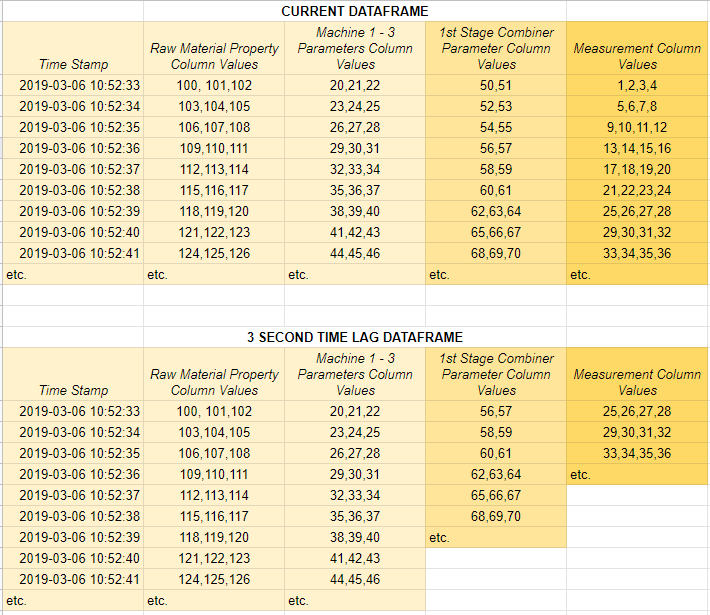

The following diagrams the parameters in the time lag dataframes, and what data columns will shift: 

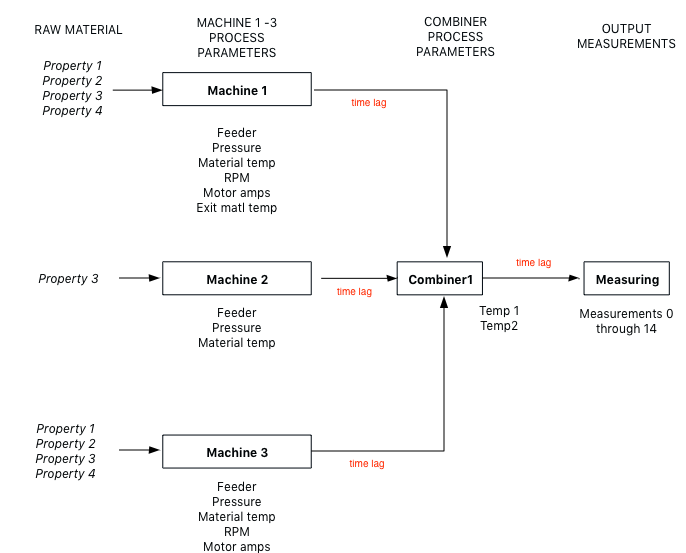

Analysis will be done with the 3 sec lag time dataframe.  Results will determine if further analysis should be done with the 5 sec lag time dataframe.

In [12]:
#create 3 sec shift dataframe
df_init3 = df_init.copy()
df_init3[fspp_cols] = (df_init3
                       [fspp_cols].shift
                       (-3, axis = 0)) 
df_init3[meas_cols] = (df_init3
                       [meas_cols].shift
                       (-6, axis = 0))
df_init3[meas_cols_sp] = (df_init3
                          [meas_cols_sp].shift
                          (-6, axis = 0))


#repeat for 5 sec shift dataframe
df_init5 = df_init.copy()
df_init5[fspp_cols] = (df_init5
                       [fspp_cols].shift
                       (-5, axis = 0)) 
df_init5[meas_cols] = (df_init5
                       [meas_cols].shift
                       (-10, axis = 0))
df_init5[meas_cols_sp] = (df_init5
                          [meas_cols_sp].shift
                          (-10, axis = 0,))


In [13]:
#check the shift on df_init3. 1st stage combiner 
#temps shift by 3s,1st stage measurements shift by 6s

df_test = pd.concat(objs = [df_init.loc[3,:],
                            df_init3.loc[0, : ],
                            df_init.loc[14087,:], 
                            df_init3.loc[14081, : ]],
                    axis=1, join='outer', ignore_index= True,
                    keys=None,levels=None, names=None, 
                    verify_integrity=False, copy=True)
df_test.columns = ['df_init', 'df_init3(3)', 
                   'df_init', 'df_init3(6)']
df_test3 = df_test.loc[fspp_cols, : ]
df_test6 = df_test.loc[meas_cols, :]

print(df_test3)
print(df_test6)

                                         df_init df_init3(3) df_init  \
FirstStage.CombinerOperation.Temp1.U.Act    99.6        99.6   113.6   
FirstStage.CombinerOperation.Temp2.U.Act   109.2       109.2     107   

                                         df_init3(6)  
FirstStage.CombinerOperation.Temp1.U.Act       118.1  
FirstStage.CombinerOperation.Temp2.U.Act       107.4  
                       df_init df_init3(3) df_init df_init3(6)
Stage1_Measure0.U.Act    12.34       12.54   12.58       12.58
Stage1_Measure1.U.Act        0           0       0           0
Stage1_Measure2.U.Act        0       11.89    8.99        8.99
Stage1_Measure3.U.Act    17.78       21.96   21.84       21.84
Stage1_Measure4.U.Act        0           0   31.55       31.55
Stage1_Measure5.U.Act        0           0       0           0
Stage1_Measure6.U.Act     3.97        3.68    2.05        2.05
Stage1_Measure7.U.Act        0        2.92    2.91        2.91
Stage1_Measure8.U.Act    19.65       20.65   20.91 

- First stage combiner temps, columns df_init and df_init3(3) match `check`
- Stage 1 Measurement, columns df_init and df_init3(6) match `check`

Based on these results, assume the df_init5 shift is also correct.

In [14]:
#look at the shifted dfs tails
df_init3.tail(7)

#NaN in correct rows/columns (`check`)

,time_stamp,Amb_Hum.U.Act,Mach1.RM.Prop1,Mach1.RM.Prop2,Mach1.RM.Prop3,Mach1.RM.Prop4,Mach1.RMFeederParameter.U.Act,Mach1.Amps.U.Act,Mach1.MotorRPM.C.Act,Mach1.Mat_Press.U.Act,Mach1.MaterialTemp.U.Act,Mach1.ExitZoneTemp.C.Act,Mach2.RM.Prop3,Mach2.RMFeederParameter.U.Act,Mach2.Mat_Press.U.Act,Mach2.MaterialTemp.U.Act,Mach3.RM.Prop1,Mach3.RM.Prop2,Mach3.RM.Prop3,Mach3.RM.Prop4,Mach3.RMFeederParameter.U.Act,Mach3.Amps.U.Act,Mach3.MotorRPM.C.Act,Mach3.Mat_Press.U.Act,Mach3.MaterialTemp.U.Act,FirstStage.CombinerOperation.Temp1.U.Act,FirstStage.CombinerOperation.Temp2.U.Act,Stage1_Measure0.U.Act,Stage1_Measure0.U.Setpoint,Stage1_Measure1.U.Act,Stage1_Measure1.U.Setpoint,Stage1_Measure2.U.Act,Stage1_Measure2.U.Setpoint,Stage1_Measure3.U.Act,Stage1_Measure3.U.Setpoint,Stage1_Measure4.U.Act,Stage1_Measure4.U.Setpoint,Stage1_Measure5.U.Act,Stage1_Measure5.U.Setpoint,Stage1_Measure6.U.Act,Stage1_Measure6.U.Setpoint,Stage1_Measure7.U.Act,Stage1_Measure7.U.Setpoint,Stage1_Measure8.U.Act,Stage1_Measure8.U.Setpoint,Stage1_Measure9.U.Act,Stage1_Measure9.U.Setpoint,Stage1_Measure10.U.Act,Stage1_Measure10.U.Setpoint,Stage1_Measure11.U.Act,Stage1_Measure11.U.Setpoint,Stage1_Measure12.U.Act,Stage1_Measure12.U.Setpoint,Stage1_Measure13.U.Act,Stage1_Measure13.U.Setpoint,Stage1_Measure14.U.Act,Stage1_Measure14.U.Setpoint
14081,2019-03-06 14:47:14,13.84,12.22,201,1048.06,252,1253.04,73.86,12.17,431.93,83.7,80.0,556.7,212.19,221.08,77.3,8.83,221,433.18,205,212.61,342.40,12.24,248.21,74.9,118.1,107.4,12.58,13.75,0.0,22.74,8.99,13.02,21.84,21.88,31.55,32.55,0.0,2.74,2.05,4.25,2.91,2.97,20.91,21.3,18.84,19.52,7.66,8.65,0.0,6.16,1.4,2.02,3.3,3.16,0.0,17.72
14082,2019-03-06 14:47:15,13.84,12.22,201,1048.06,252,1262.75,74.00,12.21,434.15,83.7,80.0,556.7,197.34,225.37,77.2,8.83,221,433.18,205,199.15,336.28,12.18,248.19,74.9,118.1,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14083,2019-03-06 14:47:16,13.84,12.22,201,1048.06,252,1263.76,73.46,12.21,424.53,83.7,80.0,556.7,208.51,227.02,77.2,8.83,221,433.18,205,195.22,337.50,12.04,248.18,74.9,118.1,108.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14084,2019-03-06 14:47:17,13.84,12.22,201,1048.06,252,1255.42,73.32,12.17,426.73,83.7,80.0,556.7,224.93,223.55,77.2,8.83,221,433.18,205,225.15,342.43,12.32,248.20,74.9,113.6,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14085,2019-03-06 14:47:18,13.84,12.22,201,1048.06,252,1257.52,73.59,12.14,429.77,83.7,80.0,556.7,207.35,222.52,77.2,8.83,221,433.18,205,210.46,334.89,12.18,248.92,74.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14086,2019-03-06 14:47:19,13.84,12.22,201,1048.06,252,1261.99,74.40,12.21,431.36,83.7,80.0,556.7,213.12,224.02,77.2,8.83,221,433.18,205,188.43,342.03,12.27,248.23,74.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14087,2019-03-06 14:47:20,13.84,12.22,201,1048.06,252,1257.40,73.86,12.17,435.96,83.7,80.0,556.7,201.35,227.68,77.3,8.83,221,433.18,205,206.17,338.27,12.19,248.22,74.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **EXPLORATORY DATA ANALYSIS (EDA), DATA CLEANING, PREPROCESSING** ##

### EVALUATE 3 SEC TIME LAG DATAFRAME ###

FURTHER DATA CLEANING

In [15]:
#count the number of values == 0 in each setpoint column

sp_dict_0 = {}
for i in meas_cols_sp:
    value = (df_init3[i] == 0).sum()
    sp_dict_0[i] = value
    

Are the 56 setpoint values ==0 for each column from the same rows? The database owner indicates all zeros in measurement setpoints for a row are when the measurement system "drops out".  

- Do further data cleaning by dropping rows where all the set point values are zero.

In [16]:
#drop all zero setpoint rows

df_init3 = df_init3.loc[(df[meas_cols_sp] > 0).all(axis=1)]

All rows with all zero in the Stage 1 measurement set points have been removed.

All measurement columns still have zeros and/or negative values.  Are these due to different products being run?  Check if there are time stamp breaks, indicating changeover to a new product

In [17]:
#create column with time stamp differences
df_init3['time_dif'] = df['time_stamp'
                         ].diff(-1).dt.total_seconds()
#any != -1?
print(df_init3['time_dif'].value_counts(bins = 10))
df_init3.loc[18:21, 'time_dif'] 

#Checked several slices where the row difference != -1. Single rows.  No indication
#operation stopped for extended period of time for part changeover.  


(-1.2, -1.0]                   14003
(-0.2, 0.0]                       14
(-2.0029999999999997, -1.8]       14
(-0.4, -0.2]                       0
(-0.6, -0.4]                       0
(-0.8, -0.6]                       0
(-1.0, -0.8]                       0
(-1.4, -1.2]                       0
(-1.6, -1.4]                       0
(-1.8, -1.6]                       0
Name: time_dif, dtype: int64


18   -1.0
19    0.0
20   -1.0
21   -1.0
Name: time_dif, dtype: float64

- No evidence of equipment changeover for a new part



The zero and negative values for the output measurements are disconcerting.  Such results are not physically possible (a missed measurement is possible, but not a zero or negative).  I'm concerned about calibration of the measurement devices and the validity of the measurement data.  This needs to be addressed.

For the purpose of completing an analysis for publication I'm going to continue, simplifying the targets from 15 to 1.

In [18]:
#drop time_dif column (no longer needed)
df_init3.drop('time_dif', axis =1, inplace = True)


FURTHER DATA CLEANING/PREPROCESSING STEPS

- Remove the rows at the end of the dataset containing 'NaN' due to the time lag shift.
- Select a single target actuals column which contains a large number of nonzero values.
- Drop the remaining target actual and setpoint columns
- Drop rows having a zero for the target actual


In [19]:
#Drop NaN rows
df_init3.drop(df.tail(6).index, inplace = True)

SELECT A TARGET VARIABLE

In [20]:
#Descriptive statistics of measurement columns for df_init3
df_init3[meas_cols].describe(include = 'all')

,Stage1_Measure0.U.Act,Stage1_Measure1.U.Act,Stage1_Measure2.U.Act,Stage1_Measure3.U.Act,Stage1_Measure4.U.Act,Stage1_Measure5.U.Act,Stage1_Measure6.U.Act,Stage1_Measure7.U.Act,Stage1_Measure8.U.Act,Stage1_Measure9.U.Act,Stage1_Measure10.U.Act,Stage1_Measure11.U.Act,Stage1_Measure12.U.Act,Stage1_Measure13.U.Act,Stage1_Measure14.U.Act
count,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,1.402600e+04,14026.000000,14026.000000,1.402600e+04,14026.000000,14026.000000,14026.000000
mean,12.940389,8.075311,11.399160,21.398533,32.996929,0.124782,1.342202,1.104704,1.983565e+01,18.037978,7.707540,1.495900e+00,1.207692,2.892686,9.983426
std,0.563214,6.898246,0.795731,1.714592,3.331032,0.571390,1.133761,1.415028,4.625146e+00,4.049815,0.992493,2.544950e+00,0.660752,0.925511,7.403726
min,0.000000,-3.132803,-4.927832,0.000000,-7.688987,-0.579891,-0.745775,-0.760350,-6.588310e-20,-0.003638,-0.001439,-1.633650e-20,-0.000356,-1.225095,-6.548924
25%,12.890000,0.000000,11.200000,21.480000,33.250000,0.000000,0.000000,0.000000,2.087000e+01,18.840000,7.730000,0.000000e+00,1.390000,3.020000,0.000000
50%,12.970000,13.260000,11.310000,21.510000,33.460000,0.000000,1.640000,0.000000,2.090000e+01,18.950000,7.840000,0.000000e+00,1.500000,3.180000,15.030000
75%,13.050000,13.870000,11.520000,21.550000,34.080000,0.000000,1.820000,2.900000,2.095000e+01,19.060000,7.920000,5.420000e+00,1.570000,3.320000,15.760000
max,20.880000,19.140000,23.530000,26.240000,34.760000,4.960000,7.030000,5.190000,2.246000e+01,20.450000,13.070000,7.470000e+00,3.950000,6.910000,22.301788


In [21]:
df_init3['Stage1_Measure10.U.Act'].value_counts().sort_index()

-0.001439       1
 0.000000     221
 4.219223       1
 4.349486       1
 7.190000       2
 7.210000       2
 7.250000       2
 7.260000       3
 7.280000       3
 7.310000       2
 7.320000       5
 7.340000       5
 7.350000       2
 7.370000       2
 7.380000       9
 7.390000      13
 7.400000       6
 7.410000       9
 7.420000       5
 7.430000       9
 7.440000       9
 7.450000      11
 7.460000       6
 7.470000       8
 7.480000      13
 7.490000      17
 7.500000      14
 7.510000      17
 7.520000      13
 7.530000      15
 7.540000      24
 7.550000      45
 7.560000      41
 7.570000      53
 7.570112       1
 7.580000      48
 7.590000      70
 7.593958       1
 7.600000     105
 7.610000      56
 7.620000     125
 7.628885       1
 7.630000     149
 7.640000     160
 7.649440       1
 7.650000     163
 7.660000     207
 7.670000     250
 7.674818       1
 7.680000     284
 7.687610       1
 7.690000     251
 7.697020       1
 7.700000     309
 7.700417       1
 7.710000 

In [22]:
# Import library and write function for histogram plotting

import matplotlib.pyplot as plt

def hist_plot(df,columns):
    fig = plt.figure(figsize = (20, 20))
    for counter,sp in enumerate(columns):
        ax = fig.add_subplot(5,3,counter+1)
        ax.set_title(sp, color = 'red')
        ax.tick_params(color = 'red', labelcolor = 'red')
        bins = 10
        plt.hist(df[sp],bins, align = 'left')

    plt.subplots_adjust(hspace = 0.5)
    plt.show()
    return

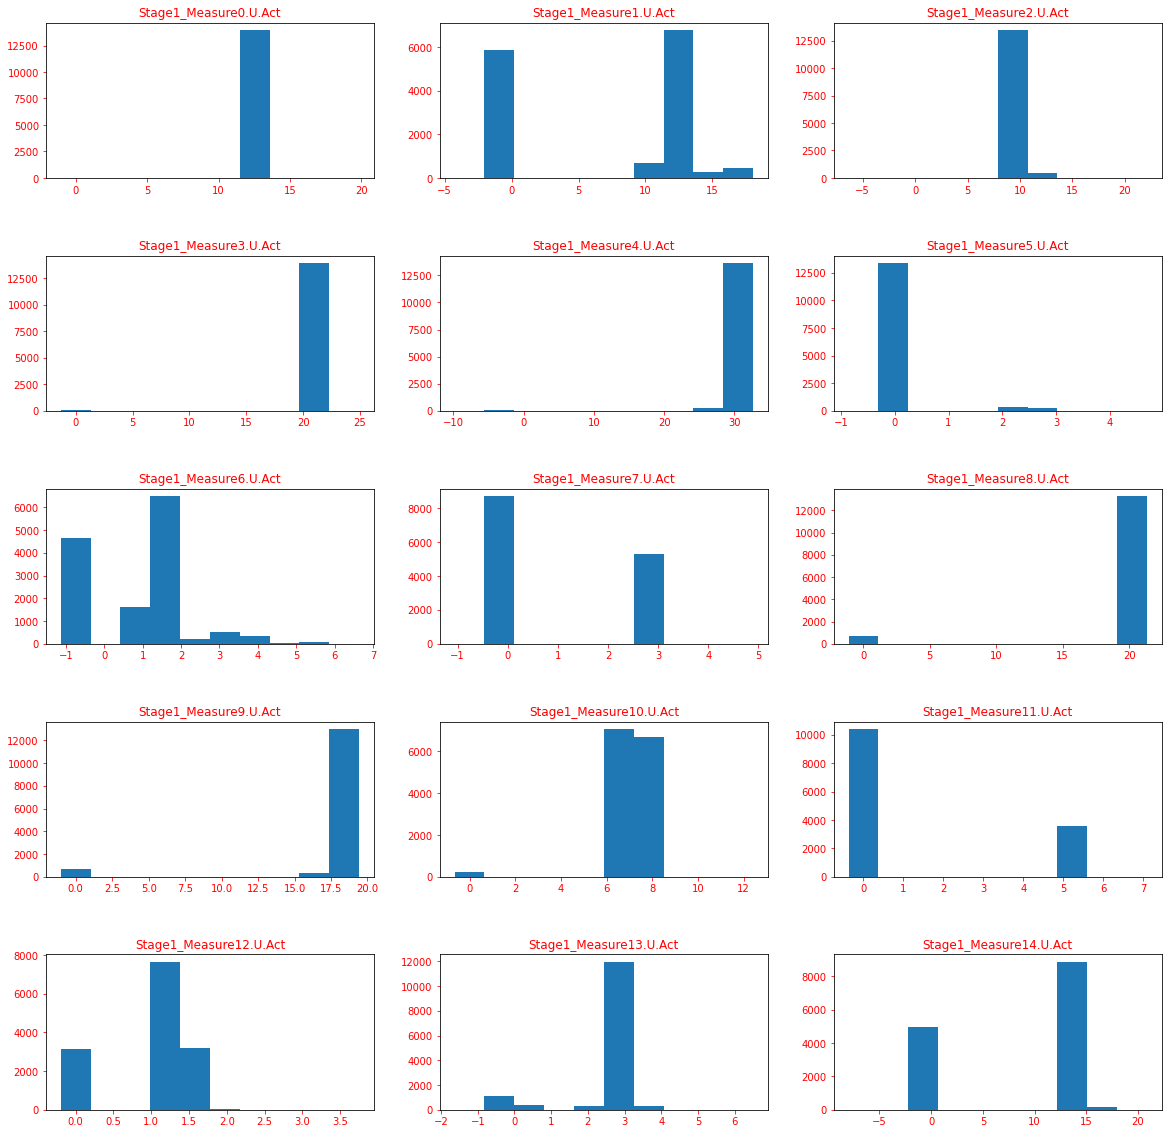

In [23]:
#histogram plot of the measurement values
hist_plot(df_init3, meas_cols)

> Measurements 10 and 13 have relatively few negative/zero values and demonstrate variation. Choose measurement 10.

In [24]:
#drop measurement columns (Act and Setpoint) != 10
rm_col = meas_cols.copy()
rm_col.remove('Stage1_Measure10.U.Act')
df_init3.drop(rm_col, axis = 1,inplace = True)

rm_colsp = meas_cols_sp.copy()
rm_colsp.remove('Stage1_Measure10.U.Setpoint')
df_init3.drop(rm_colsp,axis = 1, inplace = True)

# `checked`

In [25]:
#drop rows where Measure10 <= 0

df_init3 = df_init3[df_init3['Stage1_Measure10.U.Act'] > 0]
df_init3['Stage1_Measure10.U.Act'].describe()

count    13804.000000
mean         7.831495
std          0.173384
min          4.219223
25%          7.730000
50%          7.840000
75%          7.920000
max         13.070000
Name: Stage1_Measure10.U.Act, dtype: float64

Only measurement column that df_init3 contains is measurement 10.  Any row where measurement 10 is < 0 has been dropped.

### CREATE TRAIN, TEST DATASETS FROM 3 SEC TIME LAG DF ###

In [26]:
#create train, test datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

train3,test3 = train_test_split(df_init3, 
                                test_size = 0.25,
                                random_state = 1)
#create min/max scaled train X, also a train y

X_train3df = train3.drop(['Stage1_Measure10.U.Setpoint',
                       'Stage1_Measure10.U.Act',
                       'time_stamp'],
                      axis = 1)
scaler_train = MinMaxScaler()
scaler_train.fit(X_train3df)
X_train3 = scaler_train.transform(X_train3df)# scale
y_train3 = train3.pop('Stage1_Measure10.U.Act')

#create test X, test y (will scale test X after choosing
#model features)

X_test3 = test3.drop(['Stage1_Measure10.U.Setpoint',
                       'Stage1_Measure10.U.Act',
                       'time_stamp'],
                      axis = 1)
y_test3 = test3.pop('Stage1_Measure10.U.Act')

#SIGNIFICANT LESSON LEARNED
#Fit a LinearRegression instance to all features
#scaled using StandardScaler (suggested in scikit-learn
#docs). The resulting R2 was meaningless (-1E09).  

#However, when LinearRegression fit with MinMaxScaler 
#features the coefficients and R2 made sense (between 0
# and 1).

#Literature search indicated StandardScaler assumes 
#features are normally distributed. Looking at the
#histograms, I should not have treated any feature
#as normally distributed.

## MODELING ##

- Create a function for Recursive Feature Elimination (RFE)
- Create linear regression function
- Execute RFE function to choose features
- Execute linear regression function on the 3 sec time lag DataFrame

In [27]:
#import libraries, function for RFE selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def choose_features(X, y):
    
    lr = LinearRegression()
    grid = RFE(lr, n_features_to_select = 5, step = 1)
    grid.fit(X,y)
    rem_X = grid.transform(X)
    num_features = grid.n_features_
    column_rank = grid.ranking_
    return num_features, column_rank, rem_X


#function for linear regression
def lr_reg(X_train, X_test, y_train, y_test):
    lr = LinearRegression(fit_intercept = False)
    lr.fit(X_train, y_train)
    prediction = lr.predict(X_test)
    Rsq = lr.score(X_test, y_test)
    coefs = lr.coef_
    return Rsq, coefs, prediction

In [28]:
# call the RFE function (_rem indicates "remaining")

num_features, column_rank, X_train3_rem = (choose_features
                                           (X_train3,
                                            y_train3))

#Get list of remaining features columns after RFE by
#zipping together column_rank boolean, column names. 
#Then sort ascending, put the no. of columns equal to
#number of features into a list

zipped = dict(zip(X_train3df.columns, column_rank))
sort_zip = sorted(zipped.items(), 
                  key=lambda x: x[1], reverse=False)
sort_list =[]
for i in range(0,num_features):
    sort_list.append(sort_zip[i][0])
    
print(sort_list)

#Create X_test w/ reduced feature set
X_test3_temp = test3[sort_list]
scaler_test = MinMaxScaler()
scaler_test.fit(X_test3_temp)
X_test3_rem = scaler_test.transform(X_test3_temp)# scale

# Have reduced, scaled train and test feature arrays
# for regression and sort_list giving the feature names

['Mach2.MaterialTemp.U.Act', 'Mach3.RM.Prop1', 'Mach3.RM.Prop2', 'Mach3.RM.Prop3', 'Mach3.RM.Prop4']


In [29]:
#call linear regression function
Rsq, coefs, prediction = lr_reg(X_train3_rem, 
                    X_test3_rem, 
                    y_train3, 
                    y_test3)
print("Number of features (3s lag):", num_features, '\n',
      num_features,"Regression Rsq (3s lag):", Rsq, '\n',
      "Model coefficient names:", sort_list, '\n'
     "Model coefficents (3s lag):", coefs)

Number of features (3s lag): 5 
 5 Regression Rsq (3s lag): 0.29899599804550625 
 Model coefficient names: ['Mach2.MaterialTemp.U.Act', 'Mach3.RM.Prop1', 'Mach3.RM.Prop2', 'Mach3.RM.Prop3', 'Mach3.RM.Prop4'] 
Model coefficents (3s lag): [-1.81854146e-01 -1.93995202e+11 -9.73104981e+11  7.10719855e+10
  9.02032996e+11]


In [30]:
# what's the difference in R2 between 5 feature and all feature model?

scaler_test_all = MinMaxScaler()
scaler_test_all.fit(X_test3)
X_test3_sall = scaler_test_all.transform(X_test3)# scale all
Rsq, coefs, prediction = lr_reg(X_train3, 
                                 X_test3_sall, 
                                 y_train3, 
                                 y_test3)
print("All features regression Rsq (3s lag):", Rsq, '\n',
     "All features model coefficents (3s lag):", coefs)

All features regression Rsq (3s lag): 0.5221830974364139 
 All features model coefficents (3s lag): [-1.06158558e-01 -3.63337902e-01  8.52103279e-01  8.58357752e-01
  2.78757436e-01 -2.94549243e-02  6.89604715e-02 -2.67900495e-01
  1.06842309e-02 -1.18618599e-02 -1.23042647e-01  7.34876644e-02
  1.41870460e-02  1.43920343e-02 -8.24224716e-01  8.81808017e+00
 -2.68468281e+00  1.22248703e+01 -1.96296454e+00 -2.58672251e-02
 -5.89395469e-02  8.47482828e-02 -7.12354934e-04  3.95804074e-01
  1.71022260e-01 -1.47399231e-01]


- 5 feature model,3 sec lag df, gave an R2 of 0.30
    - 'Mach3.RM.Prop1', 'Mach3.RM.Prop2', 'Mach3.RM.Prop3', 'Mach3.RM.Prop4' coefficients were of the magnitude 1E11,1E12. Other coefficient 1E-01.
- 26 feature model,3 sec lag df, gave an R2 of 0.52
    - 'Mach3.RM.Prop1', 'Mach3.RM.Prop2', 'Mach3.RM.Prop3', 'Mach3.RM.Prop4' coefficients were of the magnitude 1E00,1E01. Other coefficients 1E-01, 1E-02.

- Why do the 4 indicated features have such large coefficients compared to the others?  Why don't the Machine 1 raw material properties have large coefficients (they're also numeric ordinal)?

With the concern about the measurement calibration and lack of process knowledge this is a good place to stop. I think some lessons learned/thoughts include:

- Need to rethink including raw material properties in the model.  The Kaggle columns show these features are numeric ordinal (they are likely continuous, but what the dataset has are only 3 or 4 values for each raw material property).  This was missed early in the analysis (my notes acknowledged the raw material properties may be numeric ordinal, but that insight got lost while performing the analysis.

- Initial potential feature removal included features where measurement error explained the measurement variability.  In my data science course this was never discussed (not surprising, since even scientists/ engineers in manufacturing don't discuss it: "Don't question the data").

- Measurement data validity needs to be addressed. Manufacturing uses equipment calibration but in this case calibration does not seem to be addressed. What are the data validity strategies for other industries?

- Originally considered choosing features based on their correlation with the target.  Instead went the RFE route.  Which is "better"? Both require a judgement call (cutoff correlation value or number of features). The calculations differ.